In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
%matplotlib inline

In [86]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [87]:
inception_weights_path = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'

In [88]:
!git clone https://github.com/laxmimerit/male-female-face-dataset.git

fatal: destination path 'male-female-face-dataset' already exists and is not an empty directory.


In [89]:
epochs = 50
lr = 1e-3
batch_size=128
data = []
labels = []

In [90]:
size = 124 #height/width

## Image data generator

In [91]:
train_datagen = ImageDataGenerator(width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   rescale=1/255,
                                   horizontal_flip=True)

In [92]:
test_gen = ImageDataGenerator(rescale=1/255)

In [93]:
target_size=(size,size)

In [94]:
train_generator = train_datagen.flow_from_directory(directory='/content/male-female-face-dataset/Training',target_size=target_size, class_mode='binary',batch_size=batch_size)

Found 47009 images belonging to 2 classes.


In [95]:
validation_generator = test_gen.flow_from_directory(directory='/content/male-female-face-dataset/Validation',target_size=target_size, class_mode='binary',batch_size=batch_size)

Found 11649 images belonging to 2 classes.


In [96]:
train_generator.class_indices

{'female': 0, 'male': 1}

In [97]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [98]:
x, y = train_generator.next()

In [99]:
x.shape # 128 is the batch size

(128, 124, 124, 3)

## Build ML model

In [100]:
model = Sequential()
model.add(InceptionV3(include_top=False, pooling = 'avg', weights='imagenet'))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(2048,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1,activation='sigmoid'))

model.layers[0].trainable=False

In [101]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_191 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_192 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_193 (Bat (None, 1024)             

In [102]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [103]:
model.fit(train_generator,steps_per_epoch=len(train_generator.filenames)//batch_size, epochs=2, validation_data=validation_generator, validation_steps=len(validation_generator)//batch_size)

Epoch 1/2
367/367 [==============================] - 185s 495ms/step - loss: 0.4585 - accuracy: 0.8109
Epoch 2/2
367/367 [==============================] - 180s 491ms/step - loss: 0.3762 - accuracy: 0.8348


## Test model

In [104]:
img_path = '/content/male.jpg'

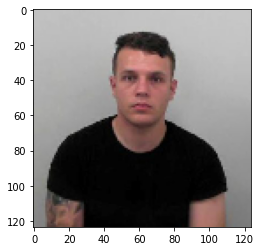

In [105]:
img = load_img(img_path, target_size=(size,size,3))
plt.imshow(img)

In [106]:
img = img_to_array(img)

In [107]:
img = img/255

In [108]:
img = img.reshape(1,size,size,3) #since there is only one image

In [109]:
img.shape

(1, 124, 124, 3)

In [110]:
model.predict(img)

array([[0.8126555]], dtype=float32)

In [127]:
def get_classes(data):
  prob = model.predict(data)[0][0]
  if prob <= 0.5:
    return 'female', prob
  else:
    return 'male', prob

In [122]:
get_classes(img)

('male', 0.8126555)

## Real time predictions using webcam


In [113]:
import imutils
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [114]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


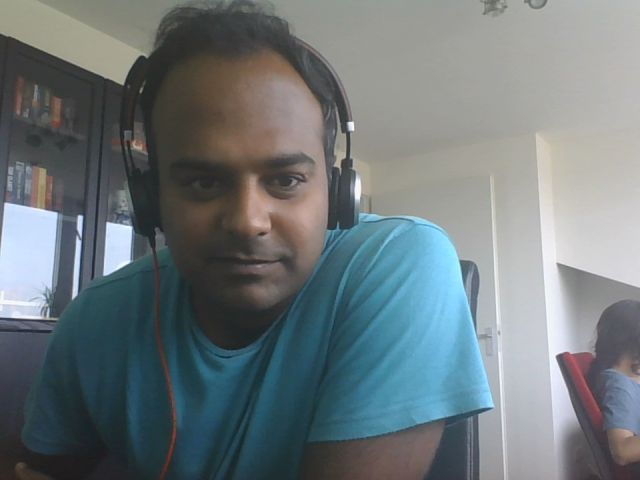

In [140]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  #show the image which was just taken.
  display(Image(filename))
except Exception as err:
  #Errors will be thrown if the user does not have a webcam or if they do no
  # grant the page permission to access it.
  print(str(err))

In [116]:
img_path = '/content/photo.jpg'

In [128]:
def get_prediction(img_path):
  img = load_img(img_path, target_size=(size, size, 3))
  plt.imshow(img)
  img = img_to_array(img)
  img = img/255.0
  img = img.reshape(1,size,size,3)
  pred, prob = get_classes(img)
  return pred,prob


('male', 0.94148135)

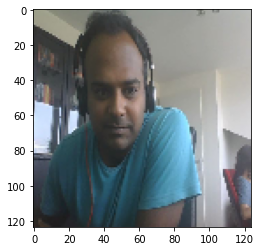

In [141]:
get_prediction('/content/photo.jpg')